In [1]:
import matplotlib.pyplot as plt
import numpy as np
import verde as vd
import harmonica as hm
import pandas as pd
from pathlib import Path
import tarfile
from io import StringIO
import xarray as xr
import xrft
import pyproj
import pygmt
import euler

import warnings
warnings.filterwarnings("ignore")

## Load data and project coords

In [2]:
tar_path = Path('../data/1038_XYZ.tar.xz')
file_path = Path('1038_XYZ/1038/spaulo_rjaneiro_rj.xyz')
file_content = None
with tarfile.open(tar_path, 'r') as tar:
    for member in tar.getmembers():
        if Path(member.name) == file_path:
            file_content = tar.extractfile(member).read().decode('ISO-8859-1')
            break
if file_content is None:
    raise FileNotFoundError(f"The specified file '{file_path}' was not found in the tar archive.")

lines = file_content.splitlines()
filtered_lines = [line for line in lines if not (line.startswith('LINE') or line.startswith('TIE'))]
filtered_data = '\n'.join(filtered_lines)
filtered_data_io = StringIO(filtered_data)

column_names = [
    'easting_m', 'northing_m', 'longitude', 'latitude', 'tfa_nT', 'THC', 'UC', 'KC', 'CTC', 
    'MAGB', 'MAGC', 'MAGD', 'THB', 'UB', 'KB', 'CTB', 'FIDU', 'TEMP', 
    'height_m', 'ALTB'
]
use_columns = [
    'longitude', 'latitude', 'tfa_nT', 'height_m',
]
df = pd.read_csv(filtered_data_io, 
                 delim_whitespace=True,
                 names=column_names,
                 usecols=use_columns,
                 skiprows=6)
df

,longitude,latitude,tfa_nT,height_m
0,-43.995255,-23.099503,434.32,300.00
1,-43.995224,-23.098618,426.28,300.00
2,-43.995193,-23.097733,418.24,300.00
3,-43.995178,-23.096832,410.20,300.00
4,-43.995148,-23.095947,402.16,300.00
...,...,...,...,...
433231,-41.949890,-20.818878,184.03,241.71
433232,-41.950882,-20.818909,179.13,241.10
433233,-41.951859,-20.818909,174.23,238.66
433234,-41.952850,-20.818924,167.32,234.70


In [3]:
# Crop area
region = [-42.65, -41.95, -22.55, -21.85]
mask = vd.inside(coordinates=[df.longitude, df.latitude], region=region)
data = df[mask]

In [4]:
# Project coordinates
projection = pyproj.Proj(proj="merc", lat_ts=data.latitude.mean())
easting, northing = projection(data.longitude.values, data.latitude.values)

data = data.assign(easting_m=easting)
data = data.assign(northing_m=northing)
data = data.reset_index()
coordinates = [data.easting_m.values, data.northing_m.values, data.height_m.values]
data

,index,longitude,latitude,tfa_nT,height_m,easting_m,northing_m
0,147806,-42.646378,-22.549759,161.74,228.60,-4.397578e+06,-2.372560e+06
1,147807,-42.646393,-22.548859,162.67,220.07,-4.397579e+06,-2.372461e+06
2,147808,-42.646408,-22.547958,163.61,210.92,-4.397581e+06,-2.372360e+06
3,147809,-42.646439,-22.547043,164.55,201.78,-4.397584e+06,-2.372259e+06
4,147810,-42.646454,-22.546143,164.49,192.33,-4.397586e+06,-2.372159e+06
...,...,...,...,...,...,...,...
63270,424373,-41.986664,-21.892532,117.10,204.83,-4.329550e+06,-2.299772e+06
63271,424374,-41.987457,-21.892517,116.17,214.58,-4.329632e+06,-2.299770e+06
63272,424375,-41.988266,-21.892502,116.23,221.89,-4.329715e+06,-2.299768e+06
63273,424376,-41.989075,-21.892471,115.30,224.03,-4.329799e+06,-2.299765e+06


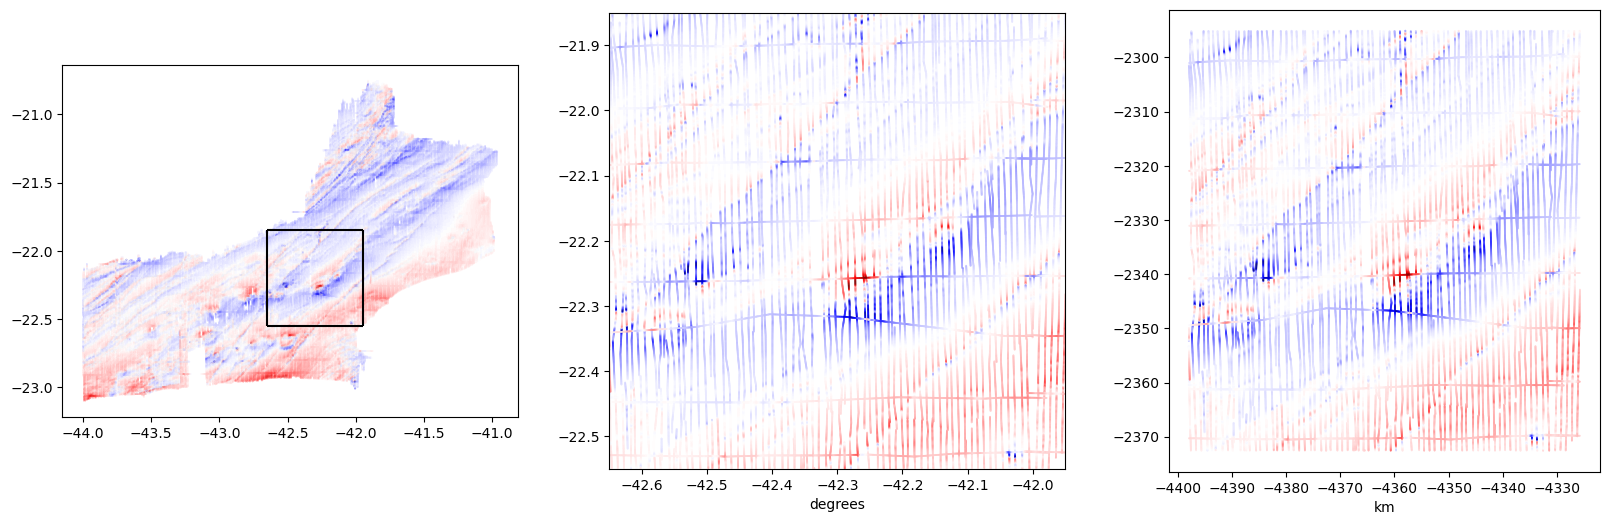

In [5]:
plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
plt.scatter(df.longitude, df.latitude, s=0.001, c=df.tfa_nT, cmap='seismic')
plt.axis('scaled')
plt.vlines(x=[region[0], region[1]], ymin=region[2], ymax=region[3], color='black')
plt.hlines(y=[region[2], region[3]], xmin=region[0], xmax=region[1], color='black')
plt.subplot(1,3,2)
plt.scatter(data.longitude, data.latitude, s=0.1, c=data.tfa_nT, cmap='seismic')
plt.xlabel('degrees')
plt.axis('scaled')
plt.xlim(region[0], region[1])
plt.ylim(region[2], region[3])
plt.subplot(1,3,3)
plt.scatter(data.easting_m/1e3, data.northing_m/1e3, s=0.1, c=data.tfa_nT, cmap='seismic')
plt.xlabel('km')
plt.axis('scaled')
plt.show()

In [6]:
# data_path = Path('../data/rio-magnetic.nc')
# data = xr.open_dataset(data_path, engine='netcdf4')
# data

## Calculate the derivatives

### Using EQS

In [7]:
eqs = hm.EquivalentSourcesGB(
    depth=1.5e3,
    damping=1e0,
    block_size=0.1e3,
    window_size=20e3,
    random_state=0,
)
eqs.fit(coordinates, data.tfa_nT)

EquivalentSourcesGB(block_size=100.0, damping=1.0, depth=1500.0, random_state=0,
                    window_size=20000.0)

In [8]:
delta_h = 10
deast = (
    eqs.predict((coordinates[0] + delta_h, coordinates[1], coordinates[2]))
    - eqs.predict((coordinates[0] - delta_h, coordinates[1], coordinates[2]))
) / (2 * delta_h)


dnorth = (
    eqs.predict((coordinates[0], coordinates[1] + delta_h, coordinates[2]))
    - eqs.predict((coordinates[0], coordinates[1] - delta_h, coordinates[2]))
) / (2 * delta_h)


delta_v = 5
dup = (
    eqs.predict((coordinates[0], coordinates[1], coordinates[2] + delta_v))
    - eqs.predict((coordinates[0], coordinates[1], coordinates[2] - delta_v))
) / (2 * delta_v)

In [9]:
data = data.assign(easting_derivative=deast)
data = data.assign(northing_derivative=dnorth)
data = data.assign(upward_derivative=dup)
data = data.assign(
    total_gradient=np.sqrt(data.easting_derivative**2 + data.northing_derivative**2 + data.upward_derivative**2)
)
data

,index,longitude,latitude,tfa_nT,height_m,easting_m,northing_m,easting_derivative,northing_derivative,upward_derivative,total_gradient
0,147806,-42.646378,-22.549759,161.74,228.60,-4.397578e+06,-2.372560e+06,0.005194,0.006473,-0.041813,0.042628
1,147807,-42.646393,-22.548859,162.67,220.07,-4.397579e+06,-2.372461e+06,0.005078,0.003774,-0.041533,0.042012
2,147808,-42.646408,-22.547958,163.61,210.92,-4.397581e+06,-2.372360e+06,0.004883,0.001232,-0.040638,0.040949
3,147809,-42.646439,-22.547043,164.55,201.78,-4.397584e+06,-2.372259e+06,0.004648,-0.001002,-0.039111,0.039399
4,147810,-42.646454,-22.546143,164.49,192.33,-4.397586e+06,-2.372159e+06,0.004320,-0.002721,-0.037137,0.037487
...,...,...,...,...,...,...,...,...,...,...,...
63270,424373,-41.986664,-21.892532,117.10,204.83,-4.329550e+06,-2.299772e+06,-0.009647,-0.024008,-0.003148,0.026065
63271,424374,-41.987457,-21.892517,116.17,214.58,-4.329632e+06,-2.299770e+06,-0.009085,-0.022051,-0.004548,0.024279
63272,424375,-41.988266,-21.892502,116.23,221.89,-4.329715e+06,-2.299768e+06,-0.008008,-0.020157,-0.005810,0.022455
63273,424376,-41.989075,-21.892471,115.30,224.03,-4.329799e+06,-2.299765e+06,-0.006561,-0.018451,-0.006805,0.020732


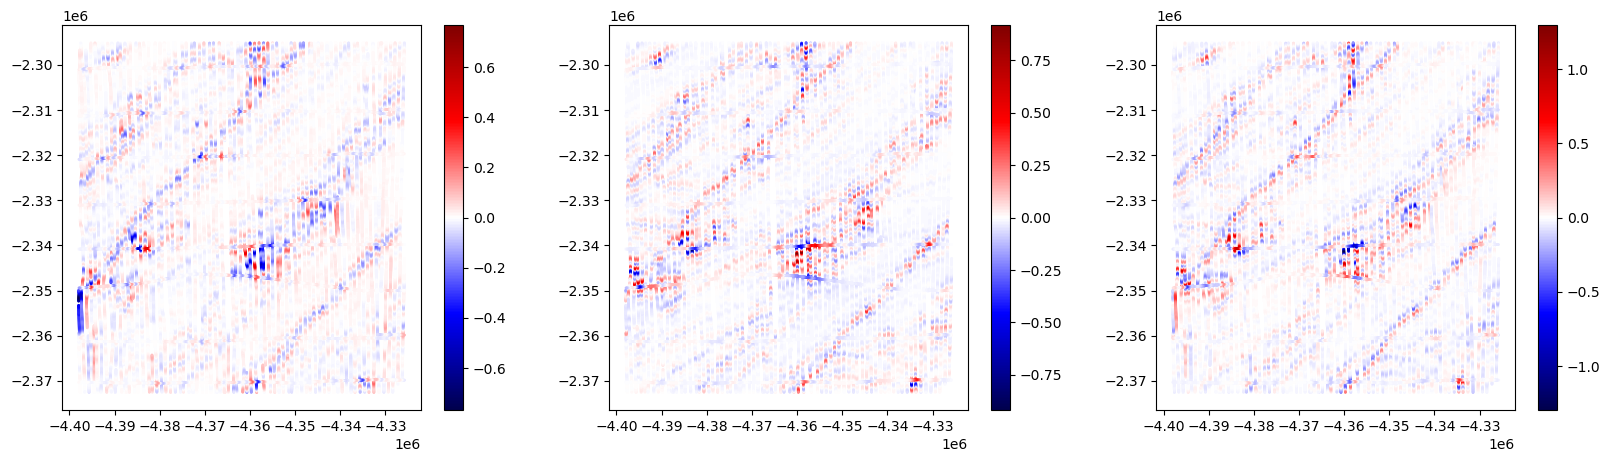

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.015, shrink=0.5)
scale = 400
# data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-3000, vmax=3000, add_colorbar=False)
axes = axes.ravel()

ax = axes[0]
tmp1 = ax.scatter(
    data.easting_m,
    data.northing_m,
    c=data.easting_derivative,
    s=1,
    cmap="seismic",
    vmin=-vd.maxabs(data.easting_derivative),
    vmax=vd.maxabs(data.easting_derivative),
)
plt.colorbar(tmp1, ax=ax)
ax.set_aspect("equal")

ax = axes[1]
tmp2 = ax.scatter(
    data.easting_m,
    data.northing_m,
    c=data.northing_derivative,
    s=1,
    cmap="seismic",
    vmin=-vd.maxabs(data.northing_derivative),
    vmax=vd.maxabs(data.northing_derivative),
)
plt.colorbar(tmp2, ax=ax)
ax.set_aspect("equal")

ax = axes[2]
tmp3 = ax.scatter(
    data.easting_m,
    data.northing_m,
    c=data.upward_derivative,
    s=1,
    cmap="seismic",
    vmin=-vd.maxabs(data.upward_derivative),
    vmax=vd.maxabs(data.upward_derivative),
)
plt.colorbar(tmp3, ax=ax)
ax.set_aspect("equal")

fig.show()

### Using Fourier Transforms (Grid)

In [11]:
# data["deriv_east"] = hm.derivative_easting(data.tfa_nT)
# data["deriv_north"] = hm.derivative_northing(data.tfa_nT)

# magnetic_grid_no_height = data.drop_vars("height_m")
# pad_width = {
#     "easting_m": data.easting_m.size // 3,
#     "northing_m": data.northing_m.size // 3,
# }
# padded = xrft.pad(
#     magnetic_grid_no_height.tfa_nT, pad_width, mode="linear_ramp", constant_values=None
# )
# data["deriv_up"] = xrft.unpad(hm.derivative_upward(padded), pad_width)
# data = data.assign(
#     total_gradient=np.sqrt(data.deriv_east**2 + data.deriv_north**2 + data.deriv_up**2)
# )
# data

In [12]:
# fig, axes = plt.subplots(1, 4, figsize=(12, 5), layout="constrained")
# for field, ax in zip(["tfa_nT", "deriv_east", "deriv_north", "deriv_up"], axes.ravel()):
#     data[field].plot.pcolormesh(
#         ax=ax, cbar_kwargs=dict(orientation="horizontal", aspect=50)
#     )
#     ax.set_aspect("equal")
# plt.show()

## Euler Deconvolution

In [13]:
window_size = 20e3
window_step = window_size / 4

In [14]:
%%time
deconvolutions = {}
euler_data = [data.tfa_nT.values, data.easting_derivative.values, data.northing_derivative.values, data.upward_derivative.values]
for si in [1, 2, 3]:
    deconvolutions[si] = euler.EulerDeconvolutionWindowed(
        structural_index=si,
        window_size=window_size,
        window_step=window_step,
        keep=0.2,
    ).fit(coordinates, data=euler_data)

CPU times: user 370 ms, sys: 8.1 ms, total: 378 ms
Wall time: 378 ms


In [15]:
# %%time
# deconvolutions = {}
# for si in [1, 2, 3]:
#     deconvolutions[si] = euler.EulerDeconvolutionWindowed(
#         structural_index=si,
#         window_size=window_size,
#         window_step=window_step,
#         keep=0.3,
#     ).fit_grid(
#         grid,
#         data_names=("tfa_nt", "deriv_east", "deriv_north", "deriv_up"),
#         coordinate_names=("easting", "northing", "upward"),
#     )

## Euler Inversion

In [16]:
%%time
ei = euler.EulerInversionWindowed(
    window_size=window_size,
    window_step=window_step,
    keep=0.10,
).fit(
    coordinates,
    data=euler_data,
)

CPU times: user 263 ms, sys: 97.5 ms, total: 361 ms
Wall time: 23.5 s


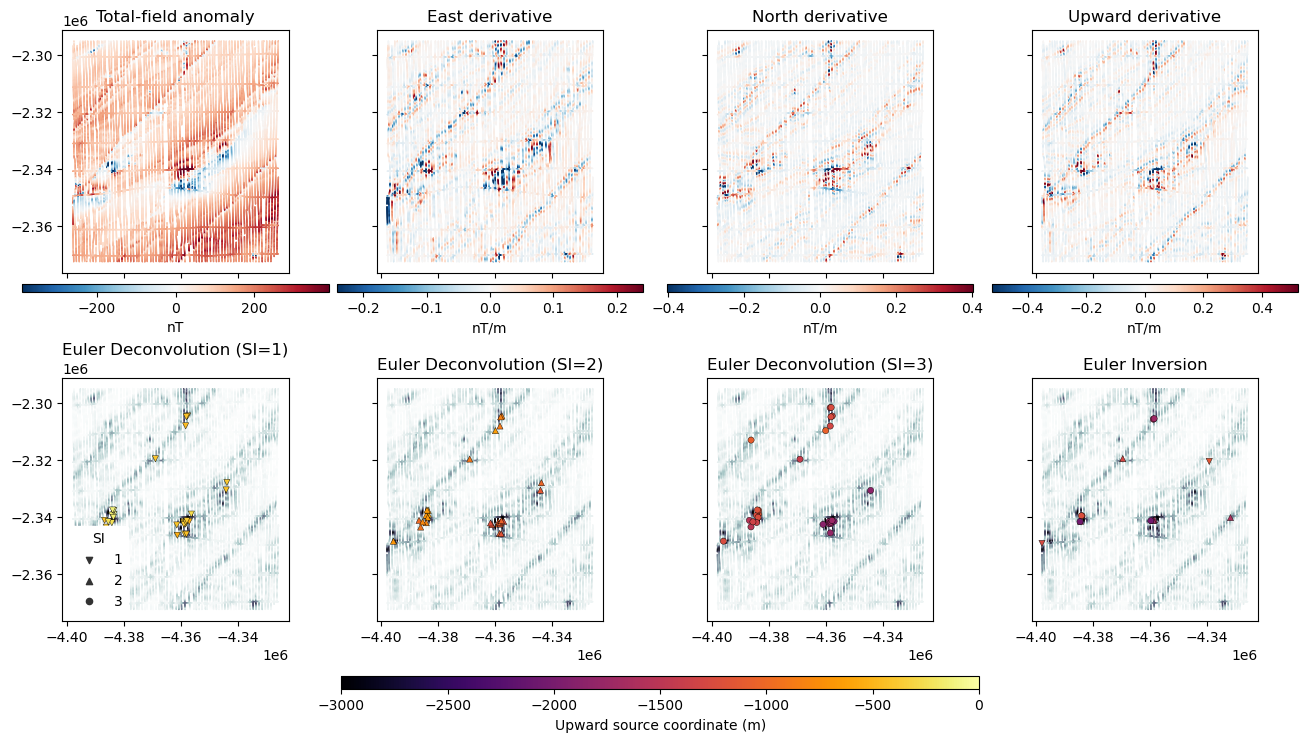

In [17]:
fig, axes = plt.subplots(
    2, 4, figsize=(13, 7.3), layout="constrained", sharey=True, sharex=True
)

subplot_labels = [f"{i})" for i in "abcdefgh"]
units = {
    "tfa_nT": "nT",
    "easting_derivative": "nT/m",
    "northing_derivative": "nT/m",
    "upward_derivative": "nT/m",
}
data_names = {
    "tfa_nT": "Total-field anomaly",
    "easting_derivative": "East derivative",
    "northing_derivative": "North derivative",
    "upward_derivative": "Upward derivative",
}
markers = ["v", "^", "o"]
marker_size = 20
vmin, vmax = -3000, 0
data_size = 1

for field, ax in zip(["tfa_nT", "easting_derivative", "northing_derivative", "upward_derivative"], axes[0, :]):
    ax.set_aspect("equal")
    scale = np.percentile(data[field].values, 99.8)
    scatter = ax.scatter(
        data.easting_m,
        data.northing_m,
        c=data[field].values,
        s=data_size,
        vmin=-scale,
        vmax=scale,
        cmap="RdBu_r",
        edgecolors="none"
    )
    fig.colorbar(
        scatter, ax=ax, orientation="horizontal", aspect=40, pad=0.02, label=units[field]
    )
    ax.set_title(data_names[field])
ax = axes[0, 0]

scale = np.percentile(data['total_gradient'].values, 99.9)
for ax in axes[1, :]:
    ax.set_aspect("equal")
    scatter = ax.scatter(
        data.easting_m,
        data.northing_m,
        c=data['total_gradient'].values,
        s=data_size,
        vmin=0,
        vmax=scale,
        cmap="bone_r",
        edgecolors="none"
    )

# Euler deconvolution
for si, marker, ax in zip([1, 2, 3], markers, axes[1, :-1]):
    ax.set_title(f"Euler Deconvolution (SI={si})")
    ax.scatter(
        *deconvolutions[si].locations_[:2],
        c=deconvolutions[si].locations_[2],
        s=marker_size,
        marker=marker,
        vmin=vmin,
        vmax=vmax,
        edgecolors="black",
        linewidths=0.3,
        cmap="inferno",
    )

# Euler inversion
labels = {}
ax = axes[1, -1]
ax.set_title("Euler Inversion")
for si, marker in zip([1, 2, 3], markers):
    is_si = ei.structural_indices_ == si
    tmp = ax.scatter(
        *ei.locations_[:2, is_si],
        c=ei.locations_[2, is_si],
        s=marker_size,
        marker=marker,
        vmin=vmin,
        vmax=vmax,
        edgecolors="black",
        linewidths=0.3,
        cmap="inferno",
    )
    labels[si] = ax.scatter([], [], c="#333333", s=marker_size, marker=marker)

axes[1, 0].legend(
    [labels[si] for si in sorted(labels)],
    sorted(labels),
    loc="lower left",
    framealpha=1,
    facecolor="#ffffff",
    edgecolor="#ffffff",
    title="SI",
)
fig.colorbar(
    tmp,
    ax=axes[1, :],
    aspect=50,
    pad=0.05,
    shrink=0.5,
    orientation="horizontal",
    label="Upward source coordinate (m)",
)

# # Optional: Adding labels, ticks, and titles
# for ax, label in zip(axes.ravel(), subplot_labels):
#     ax.text(-0.05, 1.04, label, transform=ax.transAxes)
# for ax in axes[1, :]:
#     ax.set_xticks(np.arange(0, 61e3, 20e3))
# for ax in axes[:, 0]:
#     ax.set_yticks(np.arange(0, 61e3, 20e3))
# for ax in axes[:, 0]:
#     ax.set_ylabel("Northing (m)")
# for ax in axes[1, :]:
#     ax.set_xlabel("Easting (m)")

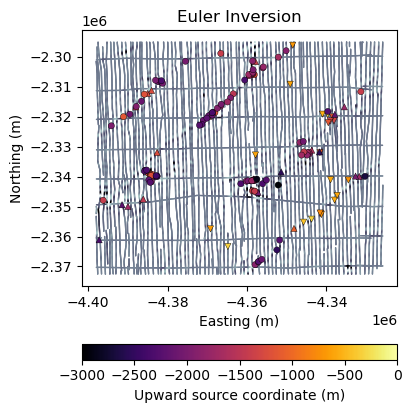

In [28]:
window_size = 15e3
window_step = window_size / 4
ei = euler.EulerInversionWindowed(
    window_size=window_size,
    window_step=window_step,
    keep=0.5,
).fit(
    coordinates,
    data=euler_data,
)

fig_last, ax_last = plt.subplots(figsize=(4, 4), constrained_layout=True)
ax_last.set_title("Euler Inversion")

scale = np.percentile(data[field].values, 99.8)
scatter_last = ax_last.scatter(
    data.easting_m,
    data.northing_m,
    c=data[field].values,
    s=data_size,
    vmin=-scale,
    vmax=scale,
    cmap="bone_r",
    edgecolors="none"
)

for si, marker in zip([1, 2, 3], markers):
    is_si = ei.structural_indices_ == si
    tmp = ax_last.scatter(
        *ei.locations_[:2, is_si],
        c=ei.locations_[2, is_si],
        s=marker_size,
        marker=marker,
        vmin=vmin,
        vmax=vmax,
        edgecolors="black",
        linewidths=0.3,
        cmap="inferno"
    )
cbar_field = plt.colorbar(tmp, ax=ax_last, orientation="horizontal", pad=0.05, label="Upward source coordinate (m)")
ax_last.set_xlabel("Easting (m)")
ax_last.set_ylabel("Northing (m)")

# Show the plot
plt.show()

In [19]:
i = 0
for i in range(10):
    print(np.sum(np.diagonal(ei.solutions_[i].covariance_)[:3]), ei.solutions_[i].structural_index)
    
for i in range(10):
    print(np.sum(np.diagonal(ei.solutions_[-i].covariance_)[:3])/3, ei.solutions_[-i].structural_index)

10104.061787030323 1
12384.02101762451 1
13172.14641553708 1
13294.807053214852 1
13574.284844443047 1
14847.485000950961 1
16041.189949590314 1
17006.23288979304 1
17551.968219104187 1
17569.685851461923 1
3368.0205956767745 1
25879.430666748336 3
25812.235873092217 1
25783.804771285842 3
25775.660672642156 1
25771.572579302345 1
25744.93835502479 3
25719.89081655115 2
25707.447772591488 1
25679.982345898712 1


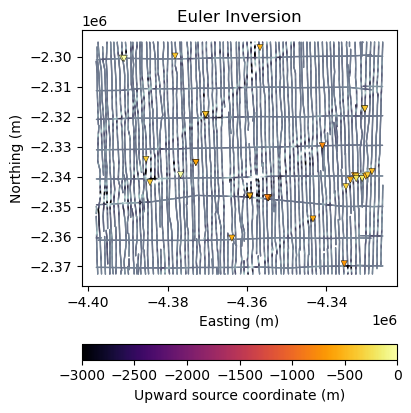

In [20]:
window_size = 5e3
window_step = window_size / 4
ei = euler.EulerInversionWindowed(
    window_size=window_size,
    window_step=window_step,
    keep=0.01,
).fit(
    coordinates,
    data=euler_data,
)

fig_last, ax_last = plt.subplots(figsize=(4, 4), constrained_layout=True)
ax_last.set_title("Euler Inversion")

scale = np.percentile(data[field].values, 99.8)
scatter_last = ax_last.scatter(
    data.easting_m,
    data.northing_m,
    c=data[field].values,
    s=data_size,
    vmin=-scale,
    vmax=scale,
    cmap="bone_r",
    edgecolors="none"
)

for si, marker in zip([1, 2, 3], markers):
    is_si = ei.structural_indices_ == si
    tmp = ax_last.scatter(
        *ei.locations_[:2, is_si],
        c=ei.locations_[2, is_si],
        s=marker_size,
        marker=marker,
        vmin=vmin,
        vmax=vmax,
        edgecolors="black",
        linewidths=0.3,
        cmap="inferno"
    )
cbar_field = plt.colorbar(tmp, ax=ax_last, orientation="horizontal", pad=0.05, label="Upward source coordinate (m)")
ax_last.set_xlabel("Easting (m)")
ax_last.set_ylabel("Northing (m)")

# Show the plot
plt.show()

In [21]:
# %%time
# ei = euler.EulerInversionWindowed(
#     window_size=window_size,
#     window_step=window_step,
#     keep=0.05,
# ).fit_grid(
#     data,
#     data_names=("tfa_nT", "deriv_east", "deriv_north", "deriv_up"),
#     coordinate_names=("easting_m", "northing_m", "height_m"),
# )

In [22]:
# fig, axes = plt.subplots(
#     2, 4, figsize=(13, 7.3), layout="constrained", sharey=True, sharex=True
# )

# subplot_labels = [f"{i})" for i in "abcdefgh"]
# units = {
#     "tfa_nT": "nT",
#     "deriv_east": "nT/m",
#     "deriv_north": "nT/m",
#     "deriv_up": "nT/m",
# }
# data_names = {
#     "tfa_nT": "Total-field anomaly",
#     "deriv_east": "East derivative",
#     "deriv_north": "North derivative",
#     "deriv_up": "Upward derivative",
# }
# markers = ["v", "^", "o"]
# vmin, vmax = -3000, 0
# size = 50


# for field, ax in zip(["tfa_nT", "deriv_east", "deriv_north", "deriv_up"], axes[0, :]):
#     ax.set_aspect("equal")
#     scale = np.percentile(data[field].values, 99.8)
#     tmp = data[field].plot.pcolormesh(
#         ax=ax,
#         add_colorbar=False,
#         add_labels=False,
#         vmax=scale,
#         vmin=-scale,
#         cmap="RdBu_r",
#     )
#     fig.colorbar(
#         tmp, ax=ax, orientation="horizontal", aspect=40, pad=0.02, label=units[field]
#     )
#     ax.set_title(data_names[field])
# ax = axes[0, 0]

# scale = np.percentile(data.total_gradient.values, 99.9)
# for ax in axes[1, :]:
#     ax.set_aspect("equal")
#     data.total_gradient.plot.pcolormesh(
#         ax=ax, add_colorbar=False, add_labels=False, vmax=scale, vmin=0, cmap="bone_r"
#     )

# # Euler deconvolution
# for si, marker, ax in zip([1, 2, 3], markers, axes[1, :-1]):
#     ax.set_title(f"Euler Deconvolution (SI={si})")
#     ax.scatter(
#         *deconvolutions[si].locations_[:2],
#         c=deconvolutions[si].locations_[2],
#         s=size,
#         marker=marker,
#         vmin=vmin,
#         vmax=vmax,
#         edgecolors="black",
#         linewidths=0.3,
#         # cmap="tab20b",
#         cmap="inferno",
#     )

# # Euler inversion
# labels = {}
# ax = axes[1, -1]
# ax.set_title("Euler Inversion")
# for si, marker in zip([1, 2, 3], markers):
#     is_si = ei.structural_indices_ == si
#     tmp = ax.scatter(
#         *ei.locations_[:2, is_si],
#         c=ei.locations_[2, is_si],
#         s=size,
#         marker=marker,
#         vmin=vmin,
#         vmax=vmax,
#         edgecolors="black",
#         linewidths=0.3,
#         # cmap="tab20b",
#         cmap="inferno",
#     )
#     labels[si] = ax.scatter([], [], c="#333333", s=size, marker=marker)

# axes[1, 0].legend(
#     [labels[si] for si in sorted(labels)],
#     sorted(labels),
#     loc="lower left",
#     framealpha=1,
#     facecolor="#ffffff",
#     edgecolor="#ffffff",
#     title="SI",
# )
# fig.colorbar(
#     tmp,
#     ax=axes[1, :],
#     aspect=50,
#     pad=0.05,
#     shrink=0.5,
#     orientation="horizontal",
#     label="Upward source coordinate (m)",
# )

# # for ax, label in zip(axes.ravel(), subplot_labels):
# #     ax.text(-0.05, 1.04, label, transform=ax.transAxes)
# # for ax in axes[1, :]:
# #     ax.set_xticks(np.arange(0, 61e3, 20e3))
# # for ax in axes[:, 0]:
# #     ax.set_yticks(np.arange(0, 61e3, 20e3))
# # for ax in axes[:, 0]:
# #     ax.set_ylabel("Northing (m)")
# # for ax in axes[1, :]:
# #     ax.set_xlabel("Easting (m)")